# A1 GradModel: 01 WholeLife
ディープラーニングフレームワークPyTorchの自動微分を用いることで，保険数理モデル（Pricing/Valuation）における最終収益性指標（EV）の基礎的アサンプション（ここでは死亡率）に対する感応度を求める．
一貫してPyTorchで記述することで，死亡率の各歳毎での感応度を求めることができる（無論，他のアサンプションに対しても可能である）．

---
## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

In [2]:
class dotdict(dict):
    __getattr__ = dict.__getitem__

---
## 1. Assumptions

In [3]:
mortality_tables = pd.read_csv('StdMort.csv')
mortality_tables.fillna(1.0, inplace=True)  # 欠損部分（高齢）は1で埋める．
mortality_tables.head(10)

,Age,Term_M,Term_F,Morb_M,Morb_F,Annuity_M,Annuity_F
0,0,0.00081,0.00078,0.00053,0.00052,0.00058,0.00047
1,1,0.00056,0.00053,0.00022,0.00020,0.00026,0.00022
2,2,0.00036,0.00033,0.00015,0.00014,0.00020,0.00015
3,3,0.00022,0.00019,0.00011,0.00009,0.00014,0.00010
4,4,0.00014,0.00011,0.00008,0.00007,0.00011,0.00007
5,5,0.00010,0.00008,0.00006,0.00006,0.00009,0.00006
6,6,0.00009,0.00008,0.00006,0.00005,0.00009,0.00006
7,7,0.00009,0.00008,0.00006,0.00005,0.00007,0.00005
8,8,0.00009,0.00007,0.00005,0.00004,0.00006,0.00004
9,9,0.00009,0.00007,0.00005,0.00004,0.00006,0.00004


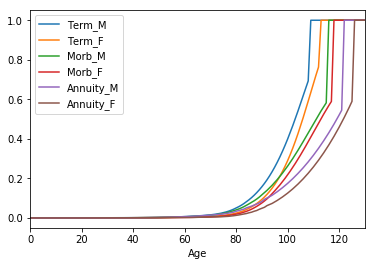

In [4]:
mortality_tables.plot(x='Age')

In [5]:
# 面倒なので，死亡保険用をV基礎（最も保守的）・医療保険料をP基礎・年金開始後用をbest estimateとして使用する．
pricing_mortality = torch.tensor(mortality_tables['Morb_M'], requires_grad=True)
reserve_mortality = torch.tensor(mortality_tables['Term_M'], requires_grad=True)
valuation_mortality = torch.tensor(mortality_tables['Annuity_M'], requires_grad=True)

In [6]:
# Assumption format
kwargs = {}

kwargs['valuation_time'] = 0
kwargs['omega'] = 121
kwargs['n'] = 100
kwargs['m'] = 30


#########################################################################################
# Pricing Assumptions
kwargs['pricing_mortality'] = pricing_mortality
kwargs['pricing_i'] = torch.tensor(1.0/100, requires_grad=True)  # interest rate
kwargs['pricing_alpha'] = torch.tensor(0.05, requires_grad=True)  # acquisition expense per face amount
kwargs['pricing_beta'] = torch.tensor(0.005, requires_grad=True)  # maintenance expense per face amount arise at BoY
kwargs['pricing_gamma'] = torch.tensor(0.05, requires_grad=True)  # maintenance expence per premium arise at BoY


#########################################################################################
# Reserve Assumptions
kwargs['reserve_mortality'] = reserve_mortality
kwargs['reserve_i'] = torch.tensor(0.5/100, requires_grad=True)


#########################################################################################
# Valuation Assumptions
kwargs['valuation_mortality_x'] = valuation_mortality
kwargs['valuation_morbidity_x'] = torch.tensor(np.zeros(kwargs['n']), requires_grad=True, dtype=torch.float32)
kwargs['valuation_lapse_t'] = torch.tensor(np.zeros(kwargs['n']), requires_grad=True, dtype=torch.float32)

kwargs['expense_volume_t'] = torch.tensor(np.concatenate([np.array([0.05, ]), np.full(kwargs['n']-1, fill_value=0.0)]), requires_grad=True, dtype=torch.float32)
kwargs['expense_case_t'] = torch.tensor(np.concatenate([np.array([0.01, ]), np.full(kwargs['n']-1, fill_value=0.001)]), requires_grad=True, dtype=torch.float32)
kwargs['expense_premium_t'] = torch.tensor(np.concatenate([np.array([0.4, ]), np.full(kwargs['n']-1, fill_value=0.03)]), requires_grad=True, dtype=torch.float32)

kwargs['investment_interest_t'] = torch.tensor(np.full((kwargs['omega'], ), fill_value=1.5/100), requires_grad=True, dtype=torch.float32)


#########################################################################################
# Other Assumptions
kwargs['capital_interest'] = torch.tensor(1.5/100, requires_grad=True, dtype=torch.float32)
kwargs['hurdle_rate'] = torch.tensor(5.0/100, requires_grad=True, dtype=torch.float32)


#########################################################################################
# IF Policies
kwargs['policy_volume_x'] = torch.tensor(np.ones(kwargs['omega']), requires_grad=True, dtype=torch.float32) 
kwargs['policy_count_x'] = torch.tensor(np.ones(kwargs['omega']), requires_grad=True, dtype=torch.float32)

---
## 2. Pricing

In [7]:
def pricing(mortality, i, alpha, beta, gamma, n=10, m=10):

    # decrement
    lx_ = torch.cumprod(1 - torch.cat([torch.zeros(1), mortality], dim=0), dim=0)
    lx = lx_[:-1]  # 年始〜最後がゼロとは限らない
    lx1 = lx_[1:]  # 年末〜最後は必ずゼロ
    dx = lx - lx1

    v = 1 / (1 + i)
    vt = torch.pow(v, torch.arange(lx.shape[0], dtype=torch.float32))  # v^t
    vh = vt * torch.pow(v, 0.5)  # v^(t+1/2)

    Dx = lx * vt
    Cx = dx * vh

    Nx = torch.flip(torch.cumsum(torch.flip(Dx, dims=(0, )), dim=0), dims=(0, ))  # of shape x
    Mx = torch.flip(torch.cumsum(torch.flip(Cx, dims=(0, )), dim=0), dims=(0, ))  # of shape x

    # 最終年齢の確定（lxが初めて0になるx）．つまり，計算上意味があるのはomega-1まで．
    omega = torch.arange(lx.shape[0])[lx.data == 0][0]
    
    # n, mの再定義・Nx,Mxの範囲修正（後の計算簡略化のため）．
    n = min(n, omega) if n!=0 else omega  # n=0は終身払い指定
    m = min(m if m!=0 else omega, n)  # m<=n
    
    # print('n={}, m={}, omega={}'.format(n, m, omega))
    Nx = torch.cat([Nx[:omega], torch.zeros(omega)], dim=0)
    Mx = torch.cat([Mx[:omega], torch.zeros(omega)], dim=0)
    
    # 販売範囲：
    # 開始年齢は0〜omega-1となる（omegaはNxが初めてゼロになる年齢，つまり，lxが初めてゼロになる年齢）
    # print(omega, Mx.shape, Nx.shape)
    P_net = (Mx[:omega] - Mx[n:omega+n]) / (Nx[:omega] - Nx[m:omega+m])
    
    P = (Mx[:omega] - Mx[n:omega+n] + alpha + (Nx[:omega] - Nx[m:omega+m]) * beta) / ((Nx[:omega] - Nx[m:omega+m]) * (1 - gamma))
    Pxt = torch.zeros(size=(omega, omega))
    Pxt[:, :m] = P.reshape(-1, 1)
        
        
    # A, a and V
    Axt = [torch.cat([(Mx[x:min(x+n, omega)] - Mx[min(x+n, omega)]) / Dx[x:min(x+n, omega)], 
                      torch.zeros(omega)], dim=0)[:omega].reshape(1, -1)
          for x in range(omega)]
    Axt = torch.cat(Axt, dim=0)
    
    Ixt = [torch.cat([P_net[x] * (Nx[x:min(x+m, omega)] - Nx[min(x+m, omega)]) / Dx[x:min(x+m, omega)], 
                      torch.zeros(omega)], dim=0)[:omega].reshape(1, -1)
          for x in range(omega)]
    Ixt = torch.cat(Ixt, dim=0)
    
    Vxt = Axt - Ixt
  
    return P, P_net, Vxt, Pxt

---
## 3. Valuation
全体の流れ〜Pから（今回，解約はとりあえず無視する），Projected CF→Asset→Risk→Distributional Earningの順に作っていく．

### Liability

In [8]:
def liability_projection(Pxt, Vxt, 
       benefit_death_t, benefit_lapse_xt, benefit_morb_t, 
       mortality_x, morbidity_x, lapse_t, 
       expense_volume_t, expense_case_t, expense_premium_t, 
       policy_volume_x, policy_count_x, T=0, omega=121):  # T means t at valuation
    # P~Pxt, V~Vxt
    
    # padding to (omega, omega) for all
    Pxt = torch.cat([torch.cat([Pxt[:, T:], torch.zeros(omega, Pxt[:, T:].shape[1])], dim=0)[:omega], 
                     torch.zeros(omega, omega)], dim=1)[:, :omega]
    Vxt = torch.cat([torch.cat([Vxt[:, T:], torch.zeros(omega, Vxt[:, T:].shape[1])], dim=0)[:omega], 
                     torch.zeros(omega, omega)], dim=1)[:, :omega]
    benefit_lapse_xt = torch.cat([torch.cat([benefit_lapse_xt[:, T:], torch.zeros(omega, benefit_lapse_xt[:, T:].shape[1])], dim=0)[:omega], 
                                  torch.zeros(omega, omega)], dim=1)[:, :omega]
    
    benefit_death_t = torch.cat([benefit_death_t[T:], torch.ones(omega)])[:omega].reshape(1, -1)
    benefit_morb_t = torch.cat([benefit_morb_t[T:], torch.ones(omega)])[:omega].reshape(1, -1)
    
    mortality_x = torch.cat([mortality_x, torch.ones(omega)])[:omega]
    morbidity_x = torch.cat([morbidity_x, torch.zeros(omega)])[:omega]
    lapse_t = torch.cat([lapse_t, torch.zeros(omega)])[:omega]
    
    expense_volume_t = torch.cat([expense_volume_t[T:], torch.zeros(omega)])[:omega].reshape(1, -1)
    expense_case_t = torch.cat([expense_case_t[T:], torch.zeros(omega)])[:omega].reshape(1, -1)
    expense_premium_t = torch.cat([expense_premium_t[T:], torch.zeros(omega)])[:omega].reshape(1, -1)

    policy_volume_x = torch.cat([policy_volume_x, torch.zeros(omega)])[:omega].reshape(-1, 1)
    policy_count_x = torch.cat([policy_count_x, torch.zeros(omega)])[:omega].reshape(-1, 1)

        
    # create xt form of each assumptions
    mortality_xt = torch.cat([torch.cat([mortality_x[x:], torch.ones(omega)])[T:T+omega].reshape(1, -1) 
                              for x in range(omega)], dim=0)
    morbidity_xt = torch.cat([torch.cat([morbidity_x[x:], torch.zeros(omega)])[T:T+omega].reshape(1, -1) 
                              for x in range(omega)], dim=0)
    lapse_xt = torch.cat([lapse_t[T:], torch.zeros(omega)])[T:T+omega].reshape(1, -1)

    
    # calc decrement
    lxt1 = torch.cumprod((1 - mortality_xt) * (1 - lapse_xt), dim=1)
    lxt = torch.cat([torch.ones(lxt1.shape[0], 1), lxt1[:, :-1]], dim=1)
    d_death_xt = lxt * mortality_xt * (1 - lapse_xt / 2)
    d_lapse_xt = lxt * lapse_xt * (1 - mortality_xt / 2)
    d_morb_xt = lxt * morbidity_xt * (lxt + lxt1) / 2
    
    
    # calc CF
    CF_premium = Pxt * lxt * policy_volume_x
    CF_benefit_death = benefit_death_t * d_death_xt * policy_volume_x
    CF_benefit_morb = benefit_morb_t * d_morb_xt * policy_volume_x
    CF_benefit_lapse = benefit_lapse_xt * d_lapse_xt * policy_volume_x
    CF_expense = expense_volume_t * lxt * policy_volume_x \
               + expense_case_t * lxt * policy_count_x \
               + expense_premium_t * CF_premium
    
    CF_total = CF_premium - CF_benefit_death - CF_benefit_morb - CF_benefit_lapse - CF_expense
    
    reserve = lxt * Vxt * policy_volume_x
    
    CF_reserve = torch.cat([reserve[:, 1:], torch.zeros(size=(omega, 1))], dim=1) - reserve
    
    
    # create output and return
    lp = dotdict
    lp.volume = lxt * policy_volume_x
    lp.volume_death = d_death_xt * policy_volume_x
    lp.volume_morb = d_morb_xt * policy_volume_x
    lp.volume_lapse = d_lapse_xt * policy_volume_x
    lp.case = lxt * policy_count_x
    lp.case_death = d_death_xt * policy_count_x
    lp.case_morb = d_morb_xt * policy_count_x
    lp.case_lapse = d_lapse_xt * policy_count_x
    
    lp.reserve = lxt * Vxt * policy_volume_x
    
    lp.premium = CF_premium
    lp.benefit_death = CF_benefit_death
    lp.benefit_morb = CF_benefit_morb
    lp.benefit_lapse = CF_benefit_lapse
    lp.expense = CF_expense
    lp.total_cashflow = CF_total
    lp.reserve_increase = CF_reserve
        
    
    return lp

### Asset

In [9]:
def asset(LPxt, time_zero_asset_x=None, i_t=torch.ones(size=(1, )) * 1.5/100):
    # padding
    omega = LPxt.volume.shape[0]
    i_t = torch.cat([i_t, torch.ones(omega) * i_t[-1]])[:omega].reshape(1, -1)
    
    if time_zero_asset_x is None:  # use reserve and cf adjustments are used as asset.
        Asset_xt = LPxt.reserve + LPxt.premium - LPxt.expense - (LPxt.benefit_death + LPxt.benefit_morb + LPxt.benefit_lapse) / 2
    else:
        pass  # 一発でやるのが少し面倒なので後回しにする．
    
    InvestmentIncome_xt = Asset_xt * i_t
    
    LPxt.asset = Asset_xt
    LPxt.investment_income = InvestmentIncome_xt
    
    return LPxt



### RequiredCapital

In [10]:
# all risks defined below output sequence (array as projection).

def required_capital(LPxt, i, ios):
    omega = LPxt.volume.shape[0]
    #i = torch.tensor(i)
    #ios = torch.tensor(ios)
    
    
    # R1 insurance risk
    R1 = (LPxt.volume - LPxt.reserve) * 0.3/1000
    
    
    # R2 assumed interest rate risk
    rf = 0.0
    rf += 0.01 * (torch.min(i, torch.tensor(1.5/100)) - 0.0/100)
    rf += 0.20 * (torch.min(i, torch.tensor(2.0/100)) - 1.5/100)
    rf += 0.80 * (torch.min(i, torch.tensor(2.5/100)) - 2.0/100)
    rf += 1.00 * (i - 2.5/100)
    R2 = rf * LPxt.reserve
    

    # R3 asset risk
    R3 = LPxt.asset * 0.01
    
    
    # R4 business risk
    R4 = LPxt.reserve * 0.0  # ignore
    
    
    # R7 minimum guarantee risk
    R7 = LPxt.reserve * 0.0  # ignore
    
    
    # R8 morbidity risk
    R8 = LPxt.reserve * 0.0  # ignore

    
    R = torch.sqrt((R1+R8)**2 + (R2+R3+R7)**2 + 1e-6) + R4  # 1e-6が無いと，capital=0の際にsqrtでエラーになるので注意．
    dR = torch.cat([R[:, 1:], torch.zeros(omega, 1)], dim=1) - R
    IoS = R * ios
    
    LPxt.required_capital_r1 = R1
    LPxt.required_capital_r2 = R2
    LPxt.required_capital_r3 = R3
    LPxt.required_capital_r4 = R4
    LPxt.required_capital_r7 = R7
    LPxt.required_capital_r8 = R8
    LPxt.required_capital = R
    
    LPxt.required_capital_increase = dR
    LPxt.interest_on_required_capital = IoS

    
    return LPxt

    

### DistributableEarnings

In [11]:
def distributable_earnings(LPxt):
    Profit_before_tax = LPxt.total_cashflow - LPxt.reserve_increase + LPxt.investment_income
    Tax_on_Profit = Profit_before_tax * 0.0
    Profit_after_tax = Profit_before_tax - Tax_on_Profit
    
    DE = Profit_after_tax - LPxt.required_capital_increase + LPxt.interest_on_required_capital
    
    LPxt.profit_before_tax = Profit_before_tax
    LPxt.tax_on_profit = Tax_on_Profit
    LPxt.profit_after_tax = Profit_after_tax
    LPxt.distributable_earnings = DE
    
    return LPxt



### EmbeddedValue

In [12]:
def embedded_value(LPxt, hurdle_rate=5.0/100):
    omega = LPxt.volume.shape[0]
    
    discount_xt = torch.cumprod(torch.ones(size=(omega, omega)) / (1+hurdle_rate), dim=1)
    
    embedded_value_x = torch.sum(LPxt.distributable_earnings * discount_xt, dim=1)
    
    return embedded_value_x



### ValuationIntegration

In [13]:
def valuation(Pxt, Vxt,
             benefit_death_t, benefit_lapse_xt, benefit_morb_t,
             mortality_x, morbidity_x, lapse_t,
             expense_volume_t, expense_case_t, expense_premium_t,
             policy_volume_x, policy_count_x, T, omega, 
             assumed_interest, investment_interest_t, capital_interest, 
             hurdle_rate):
    
    
    Projection_xt = liability_projection(Pxt, Vxt, 
       benefit_death_t, benefit_lapse_xt, benefit_morb_t, 
       mortality_x, morbidity_x, lapse_t, 
       expense_volume_t, expense_case_t, expense_premium_t, 
       policy_volume_x, policy_count_x, T, omega)
    
    asset(Projection_xt, None, investment_interest_t)
    
    required_capital(Projection_xt, assumed_interest, capital_interest)
    
    distributable_earnings(Projection_xt)
    
    EV_x = embedded_value(Projection_xt, hurdle_rate)
    
    return Projection_xt, EV_x
    
    

---
### IntegratedSystem

In [14]:
def integrated_system(
    pricing_mortality, pricing_i, pricing_alpha, pricing_beta, pricing_gamma, n, m, 
    reserve_mortality, reserve_i, 
    valuation_mortality_x, valuation_morbidity_x, valuation_lapse_t, 
    expense_volume_t, expense_case_t, expense_premium_t, 
    investment_interest_t, capital_interest,
    policy_volume_x, policy_count_x, valuation_time, omega, 
    hurdle_rate):
    _, _, Rxt, Pxt = pricing(pricing_mortality, pricing_i, 
                             alpha=pricing_alpha, beta=pricing_beta, gamma=pricing_gamma, 
                             n=n, m=m)
    _, _, Vxt, _ = pricing(reserve_mortality, reserve_i, 
                           alpha=pricing_alpha, beta=pricing_beta, gamma=pricing_gamma, 
                           n=n, m=m)
    
    benefit_death_t = torch.cat([torch.ones(size=(n, ), dtype=torch.float32), 
                             torch.zeros(size=(omega, ), dtype=torch.float32)], dim=0)[:omega]
    benefit_morb_t = torch.zeros(size=(omega, ))
    
    projection_xt, EV_x = valuation(Pxt, Vxt, 
                                    benefit_death_t, Rxt, benefit_morb_t, 
                                    valuation_mortality_x, valuation_morbidity_x, valuation_lapse_t, 
                                    expense_volume_t, expense_case_t, expense_premium_t, 
                                    policy_volume_x, policy_count_x, valuation_time, omega, 
                                    reserve_i, investment_interest_t, capital_interest,
                                    hurdle_rate
                                   )
    
    return Pxt, Rxt, Vxt, projection_xt, EV_x
    
    

---
## 4. Results

In [15]:
Pxt, Rxt, Vxt, projection_xt, EV_x = integrated_system(**kwargs)

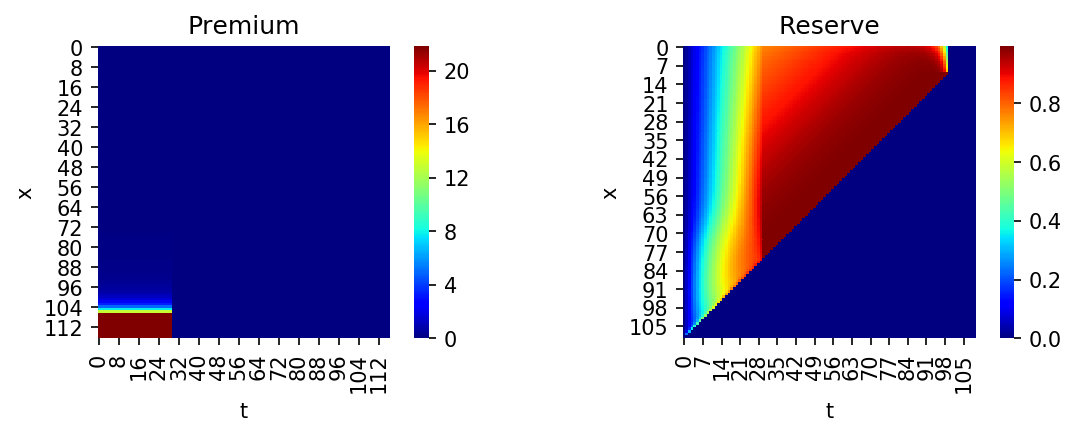

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=150)
sns.heatmap(np.array(Pxt.data), robust=True, square=True, cmap='jet', ax=axs[0])
axs[0].set_title('Premium')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x')

sns.heatmap(np.array(Vxt.data), robust=True, square=True, cmap='jet', ax=axs[1])
axs[1].set_title('Reserve')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x')

plt.tight_layout()
plt.show()

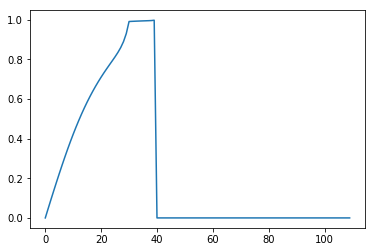

In [17]:
plt.plot(np.array(Vxt.data)[70,:])
plt.show()

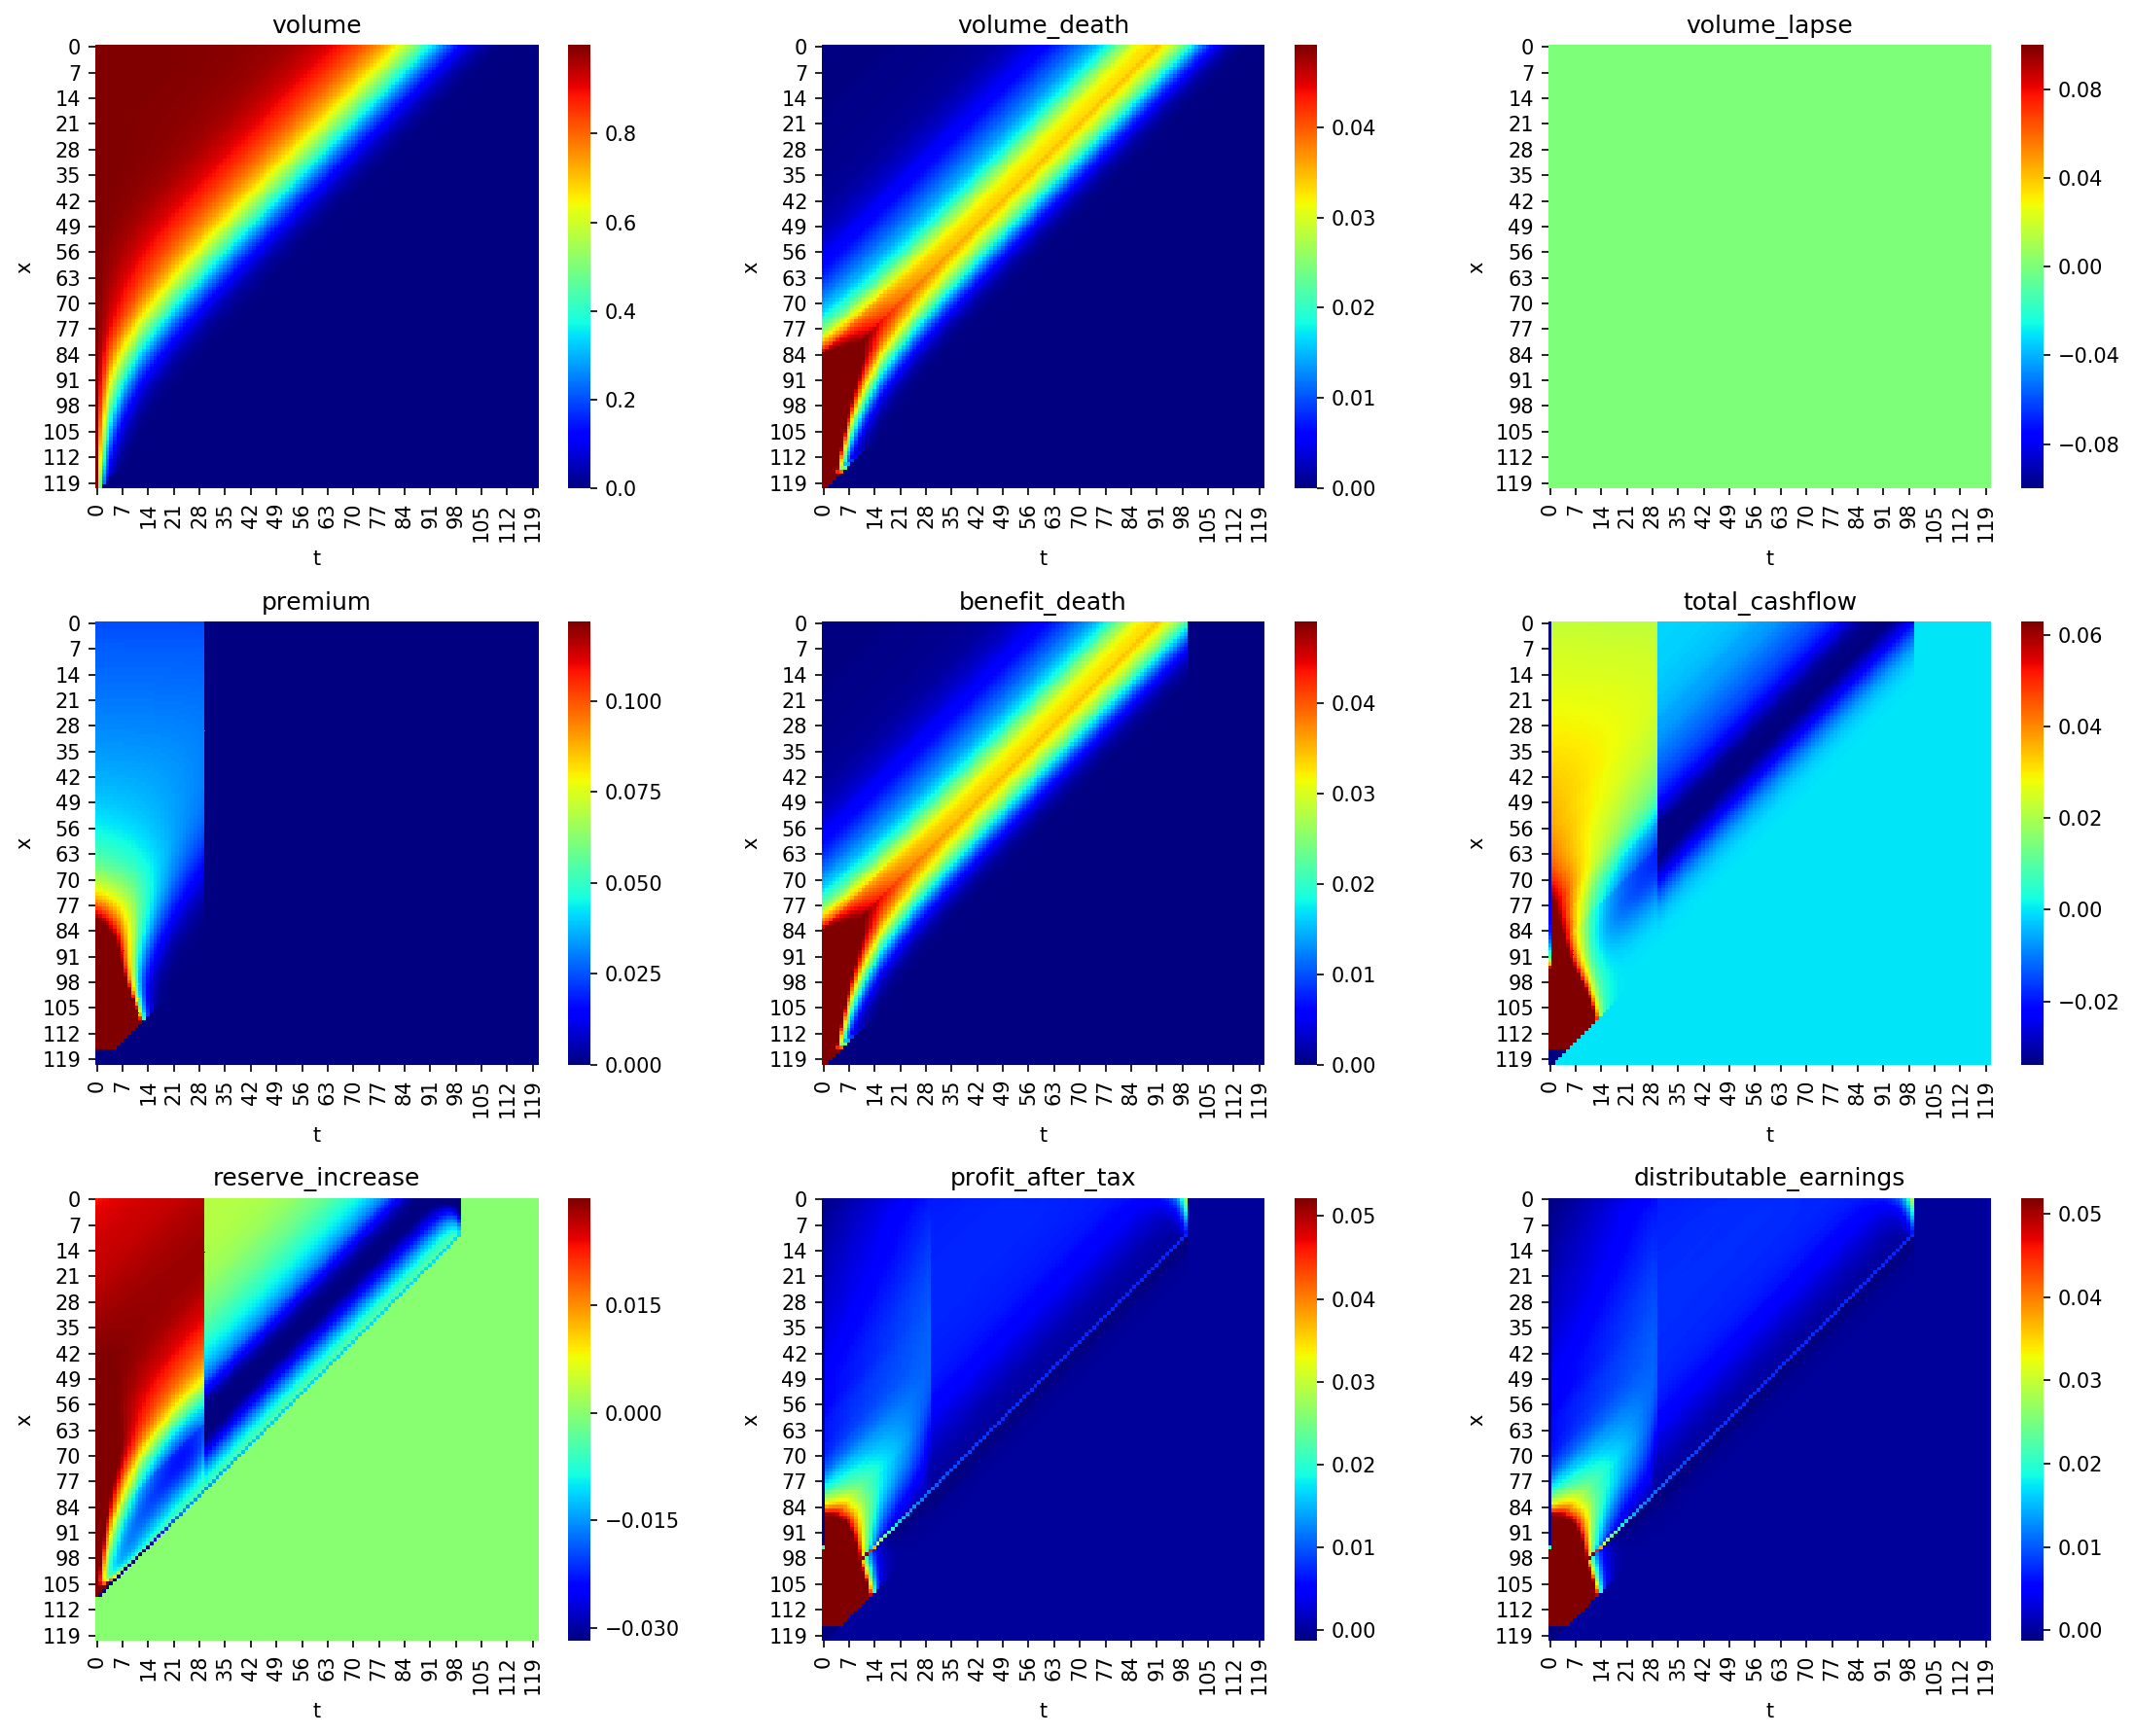

In [18]:
def show_inside(LP):
    def _show(tensor_obj, ax, title):
        sns.heatmap(np.array(tensor_obj.data), cmap='jet', robust=True, ax=ax, square=True)
        ax.set_title(title)
        ax.set_xlabel('t')
        ax.set_ylabel('x')
    
    fig, axs = plt.subplots(3, 3, figsize=(15, 12), dpi=150)
    _show(LP.volume, axs[0, 0], 'volume')
    _show(LP.volume_death, axs[0, 1], 'volume_death')
    _show(LP.volume_lapse, axs[0, 2], 'volume_lapse')
    
    _show(LP.premium, axs[1, 0], 'premium')
    _show(LP.benefit_death, axs[1, 1], 'benefit_death')
    _show(LP.total_cashflow, axs[1, 2], 'total_cashflow')
    
    _show(LP.reserve_increase, axs[2, 0], 'reserve_increase')
    _show(LP.profit_after_tax, axs[2, 1], 'profit_after_tax')
    _show(LP.distributable_earnings, axs[2, 2], 'distributable_earnings')

    plt.tight_layout()
    plt.show()


show_inside(projection_xt)

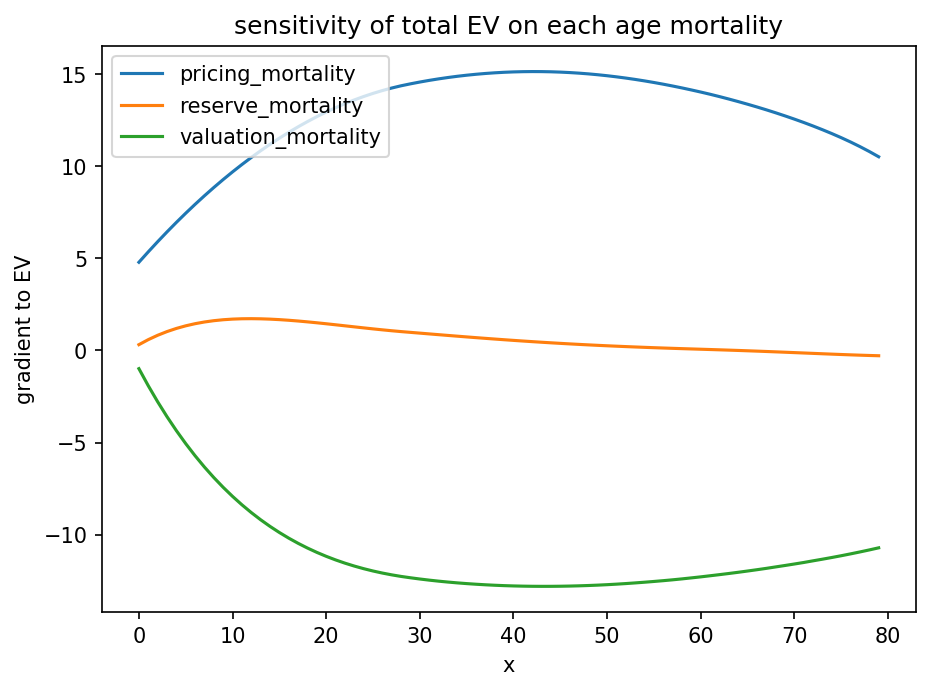

In [19]:
# 全体計算を行う際は，超高齢域は入れない方が良い．超高齢域は保険料が異常に大きくなり，他の部分の特徴が潰れて見えなくなってしまう．
torch.sum(EV_x[:80]).backward()

fig = plt.figure(figsize=(7, 5), dpi=150)
plt.plot(np.array(pricing_mortality.grad.data)[:80], label='pricing_mortality')
plt.plot(np.array(reserve_mortality.grad.data)[:80], label='reserve_mortality')
plt.plot(np.array(valuation_mortality.grad.data)[:80], label='valuation_mortality')
plt.title('sensitivity of total EV on each age mortality')
plt.xlabel('x')
plt.ylabel('gradient to EV')
plt.legend()
plt.show()

In [20]:
pri = []
res = []
val = []
#val_lapse = []
for x in range(80):  # ここは恐らくもっと良い書き方があるのではないか？
    pricing_mortality.grad.data.zero_()
    reserve_mortality.grad.data.zero_()
    valuation_mortality.grad.data.zero_()
    #kwargs['valuation_lapse_t'].grad.data.zero_()


    Pxt, Rxt, Vxt, projection_xt, EV_x = integrated_system(**kwargs)
    
    EV_x[x].backward()
    pri.append(np.copy(np.array(pricing_mortality.grad.data)))
    res.append(np.copy(np.array(reserve_mortality.grad.data)))
    val.append(np.copy(np.array(valuation_mortality.grad.data)))
    #val_lapse.append(np.copy(np.array(kwargs['valuation_lapse_t'].grad.data)))
    
    
pri = np.array(pri)
res = np.array(res)
val = np.array(val)
#val_lapse = np.array(val_lapse)

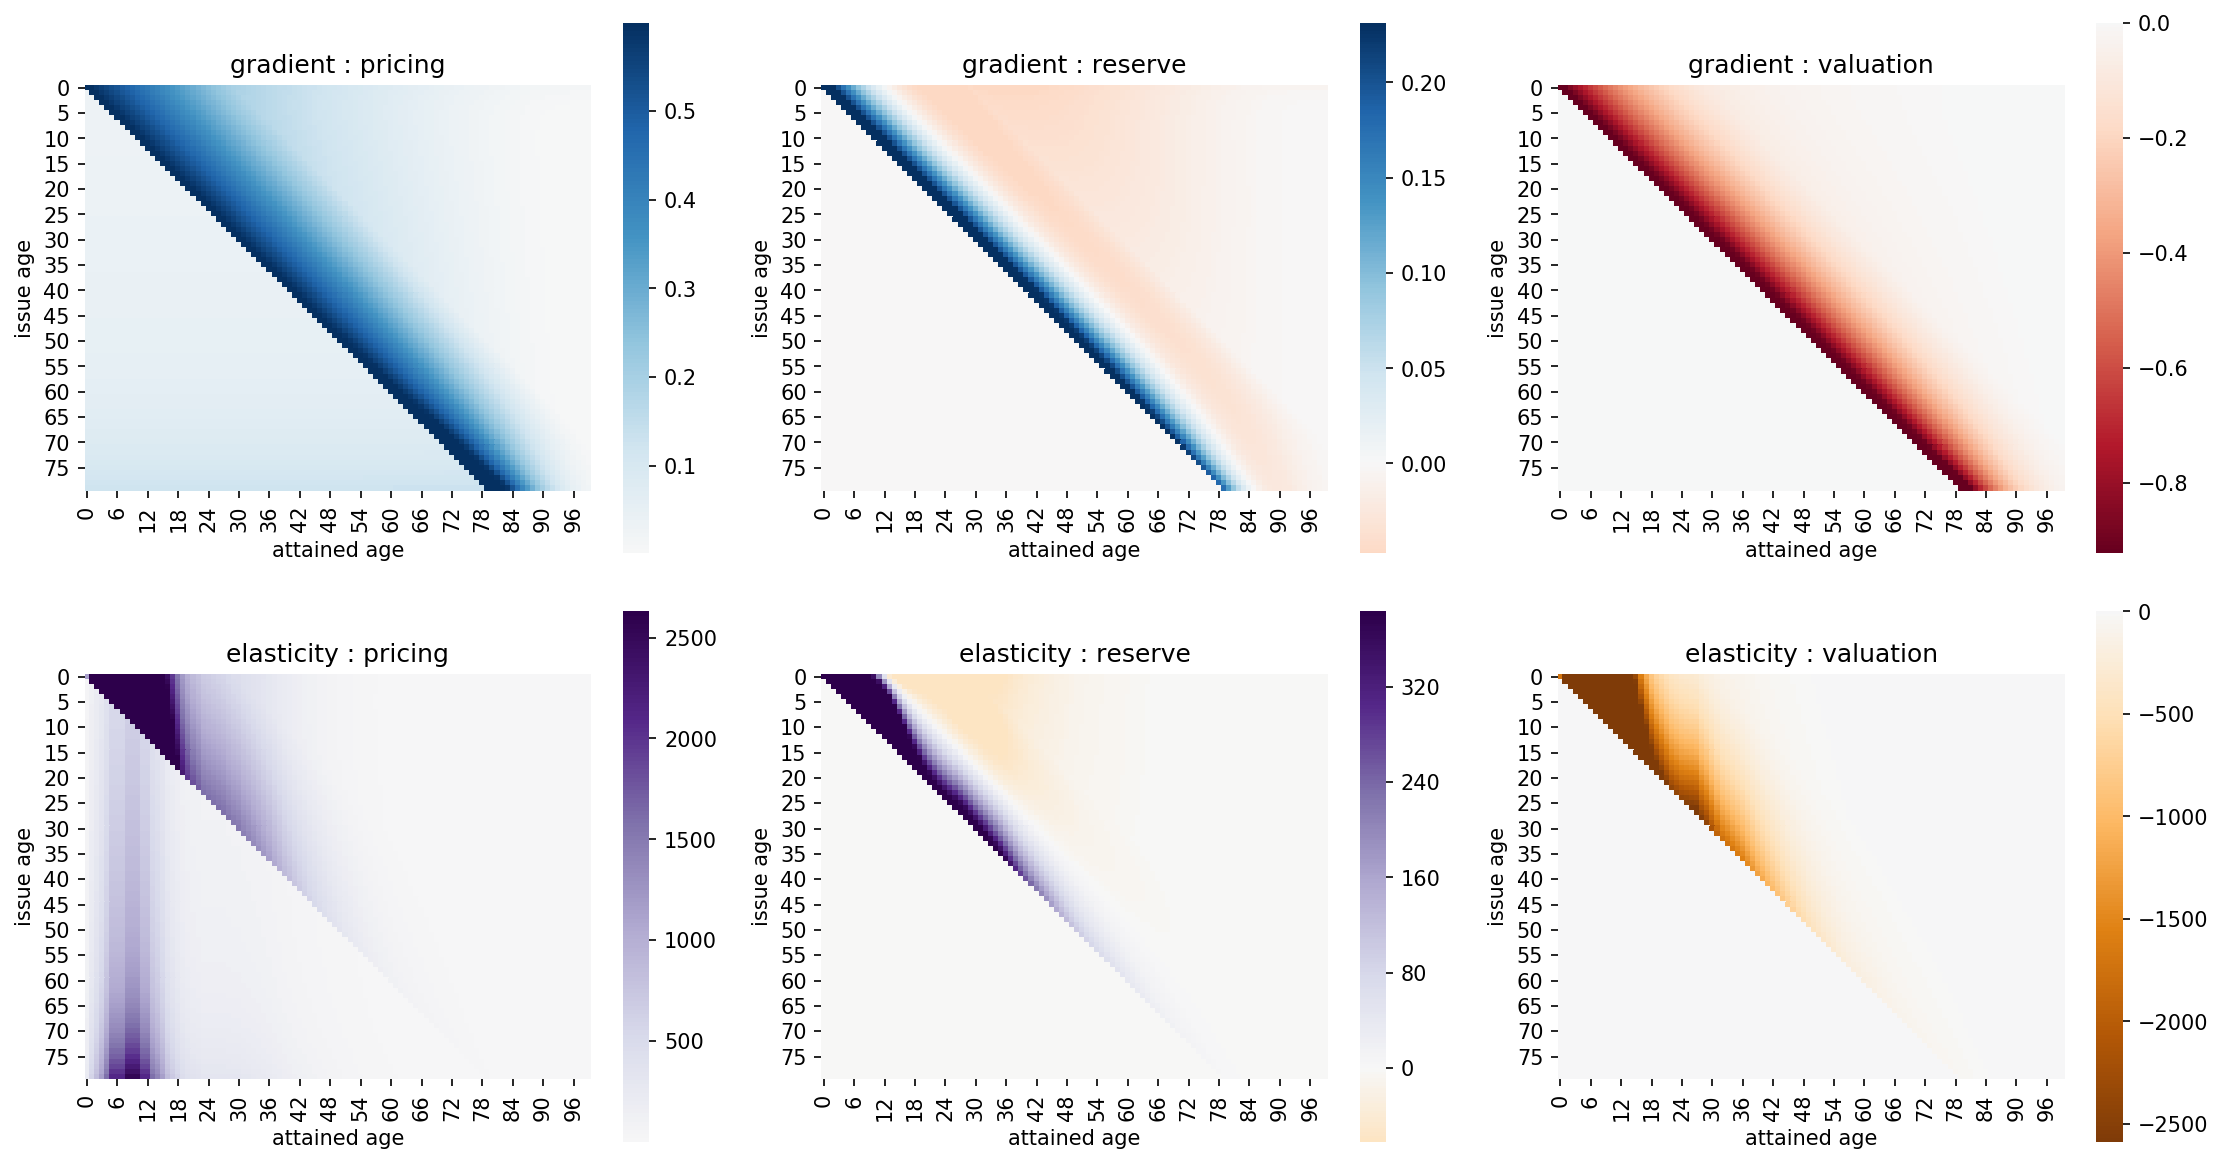

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), dpi=150)

sns.heatmap(pri[:, :100], robust=True, square=True, cmap='RdBu', ax=axs[0, 0], center=0.0)
axs[0, 0].set_title('gradient : pricing')
axs[0, 0].set_xlabel('attained age')
axs[0, 0].set_ylabel('issue age')

sns.heatmap(res[:, :100], robust=True, square=True, cmap='RdBu', ax=axs[0, 1], center=0.0)
axs[0, 1].set_title('gradient : reserve')
axs[0, 1].set_xlabel('attained age')
axs[0, 1].set_ylabel('issue age')

sns.heatmap(val[:, :100], robust=True, square=True, cmap='RdBu', ax=axs[0, 2], center=0.0)
axs[0, 2].set_title('gradient : valuation')
axs[0, 2].set_xlabel('attained age')
axs[0, 2].set_ylabel('issue age')

#sns.heatmap(val_lapse[:, :100], robust=True, square=True, cmap='RdBu', ax=axs[0, 3], center=0.0)
#axs[0, 3].set_title('gradient : valuation')
#axs[0, 3].set_xlabel('attained age')
#axs[0, 3].set_ylabel('t')


sns.heatmap((pri/np.array(pricing_mortality.data))[:, :100], robust=True, square=True, cmap='PuOr', ax=axs[1, 0], center=0.0)
axs[1, 0].set_title('elasticity : pricing')
axs[1, 0].set_xlabel('attained age')
axs[1, 0].set_ylabel('issue age')

sns.heatmap((res/np.array(reserve_mortality.data))[:, :100], robust=True, square=True, cmap='PuOr', ax=axs[1, 1], center=0.0)
axs[1, 1].set_title('elasticity : reserve')
axs[1, 1].set_xlabel('attained age')
axs[1, 1].set_ylabel('issue age')

sns.heatmap((val/np.array(valuation_mortality.data))[:, :100], robust=True, square=True, cmap='PuOr', ax=axs[1, 2], center=0.0)
axs[1, 2].set_title('elasticity : valuation')
axs[1, 2].set_xlabel('attained age')
axs[1, 2].set_ylabel('issue age')

#sns.heatmap((val_lapse/kwargs['valuation_lapse_t'].data)[:, :100], robust=True, square=True, cmap='PuOr', ax=axs[1, 3], center=0.0)
#axs[1, 3].set_title('elasticity : valuation')
#axs[1, 3].set_xlabel('t')
#axs[1, 3].set_ylabel('issue age')

plt.tight_layout()
plt.show()

# reserve_mortalityの開始直の感応度が正であるのは，V基礎死亡率を開始直後のみ上げると，負値V気味になることで逆にVが下がってしまうためと考えられる．
# 通常の感応度チェックでは死亡率全体を上げたり下げたりするため，この現象が生じることは無い．

In [22]:
# Assumption format
kwargs = {}

kwargs['valuation_time'] = 0
kwargs['omega'] = 121
kwargs['n'] = 100
kwargs['m'] = 30


#########################################################################################
# Pricing Assumptions
kwargs['pricing_mortality'] = pricing_mortality
kwargs['pricing_i'] = torch.tensor(1.0/100, requires_grad=True)  # interest rate
kwargs['pricing_alpha'] = torch.tensor(0.05, requires_grad=True)  # acquisition expense per face amount
kwargs['pricing_beta'] = torch.tensor(0.005, requires_grad=True)  # maintenance expense per face amount arise at BoY
kwargs['pricing_gamma'] = torch.tensor(0.05, requires_grad=True)  # maintenance expence per premium arise at BoY


#########################################################################################
# Reserve Assumptions
kwargs['reserve_mortality'] = reserve_mortality
kwargs['reserve_i'] = torch.tensor(0.5/100, requires_grad=True)


#########################################################################################
# Valuation Assumptions
kwargs['valuation_mortality_x'] = valuation_mortality
kwargs['valuation_morbidity_x'] = torch.tensor(np.zeros(kwargs['n']), requires_grad=True, dtype=torch.float32)
kwargs['valuation_lapse_t'] = torch.tensor(np.zeros(kwargs['n']), requires_grad=True, dtype=torch.float32)

kwargs['expense_volume_t'] = torch.tensor(np.concatenate([np.array([0.05, ]), np.full(kwargs['n']-1, fill_value=0.0)]), requires_grad=True, dtype=torch.float32)
kwargs['expense_case_t'] = torch.tensor(np.concatenate([np.array([0.01, ]), np.full(kwargs['n']-1, fill_value=0.001)]), requires_grad=True, dtype=torch.float32)
kwargs['expense_premium_t'] = torch.tensor(np.concatenate([np.array([0.4, ]), np.full(kwargs['n']-1, fill_value=0.03)]), requires_grad=True, dtype=torch.float32)

kwargs['investment_interest_t'] = torch.tensor(np.full((kwargs['omega'], ), fill_value=1.5/100), requires_grad=True, dtype=torch.float32)


#########################################################################################
# Other Assumptions
kwargs['capital_interest'] = torch.tensor(1.5/100, requires_grad=True, dtype=torch.float32)
kwargs['hurdle_rate'] = torch.tensor(5.0/100, requires_grad=True, dtype=torch.float32)


#########################################################################################
# IF Policies
kwargs['policy_volume_x'] = torch.tensor(np.ones(kwargs['omega']), requires_grad=True, dtype=torch.float32) 
kwargs['policy_count_x'] = torch.tensor(np.ones(kwargs['omega']), requires_grad=True, dtype=torch.float32)